# 1. Import

In [41]:
from basic_functions import data_load, evaluate_model, save_df
import pandas as pd
import numpy as np


In [42]:
#Load Datasets
X_train = data_load("data/X_train.csv")
y_train = data_load("data/y_train_clustered.csv")

Data loaded!
Data loaded!


# 2. CategoricalNB

## 2.1 Initial model Pipeline

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer


pipe_catnb = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("nb", CategoricalNB())
])

### 2.1.1 Gridsearch & Cross Validate Function

In [44]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

def run_gridsearch(pipe, param_grid, X, y, name):
    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        refit=True
    )

    gs.fit(X, y)
    print(f"{name} best params: {gs.best_params_} | best f1: {gs.best_score_:.4f}")
    return gs


In [45]:
from sklearn.model_selection import cross_validate

def calculate_cv(pipeline, X, y, cv, scoring, show_results = True):

    cv_results   = cross_validate(pipeline, X.astype("category"), y, cv=cv, scoring=scoring)
    
    if show_results:
        for metric in scoring.keys():
            mean = cv_results[f"test_{metric}"].mean()
            std = cv_results[f"test_{metric}"].std()
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

    return cv_results

In [46]:
_ = calculate_cv(pipeline=pipe_catnb, X= X_train, y=y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.6094 ± 0.0035
f1_macro: 0.5402 ± 0.0100
neg_log_loss: -0.9831 ± 0.0231


In [47]:
param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}
gs_catnb = run_gridsearch(pipe=pipe_catnb, param_grid=param_grid, X= X_train, y=y_train["income"], name="CatNB")

CatNB best params: {'nb__alpha': 0.001} | best f1: 0.5519


In [48]:
_ = calculate_cv(gs_catnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.6116 ± 0.0039
f1_macro: 0.5519 ± 0.0109
neg_log_loss: -0.9987 ± 0.0205


## Evaluation on Test Data

In [49]:
df_evaluation = {}

In [50]:
X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")

y_pred_catnb = gs_catnb.predict(X_test)
y_probs_catnb = gs_catnb.predict_proba(X_test)

Data loaded!
Data loaded!


In [51]:
catnb_eval = evaluate_model(y_pred=y_pred_catnb, y_test=y_test, model_name="CategoricalNB", y_proba=y_probs_catnb)

CategoricalNB:
Accuracy: 0.602428603552957
Macro-F1: 0.5507745665897843
Weighted-F1: 0.6037257411070653
Log-Loss: 1.0076337913910127
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      1741
           1       0.55      0.51      0.53      1581
           2       0.51      0.60      0.55       986
           3       0.39      0.42      0.41       139

    accuracy                           0.60      4447
   macro avg       0.55      0.56      0.55      4447
weighted avg       0.61      0.60      0.60      4447



--> still bad results.

## 2.2 Problem visualization

### 2.2.1 Dataframe for analysis

In [52]:
clf = CategoricalNB(alpha=0.001)
clf.fit(X_train, y_train)
X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")

Data loaded!
Data loaded!


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
import numpy as np
probs = clf.predict_proba(X_test)
class_labels = clf.classes_

bestfit = np.argmax(probs, axis=1)
probs_masked = probs.copy()
probs_masked[np.arange(len(probs)), bestfit] = -1
secbestfit = np.argmax(probs_masked, axis=1)

top1_labels = class_labels[bestfit]
top2_labels = class_labels[secbestfit]

# max probability for each sample
max_probs = np.max(probs, axis = 1)
print(max_probs)

[0.71195102 0.84031293 0.68961532 ... 0.881805   0.88442328 0.63352597]


In [54]:
# entropy for each sample
from scipy.stats import entropy
entropies = entropy(probs, axis=1)

In [55]:
y_test = y_test.reset_index(drop=True)

confusion_pairs = pd.DataFrame({
    "true_label": y_test["income"].values,
    "predicted_top1": top1_labels,
    "predicted_top2": top2_labels,
    "max_probability": max_probs,
    "entropy": entropies
})
confusion_pairs["is_correct"] = confusion_pairs["true_label"] == confusion_pairs["predicted_top1"]

### 2.2.2 Confusion and misclassification

In [56]:

pair_counts = (
    confusion_pairs
    .groupby(["predicted_top1", "predicted_top2"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

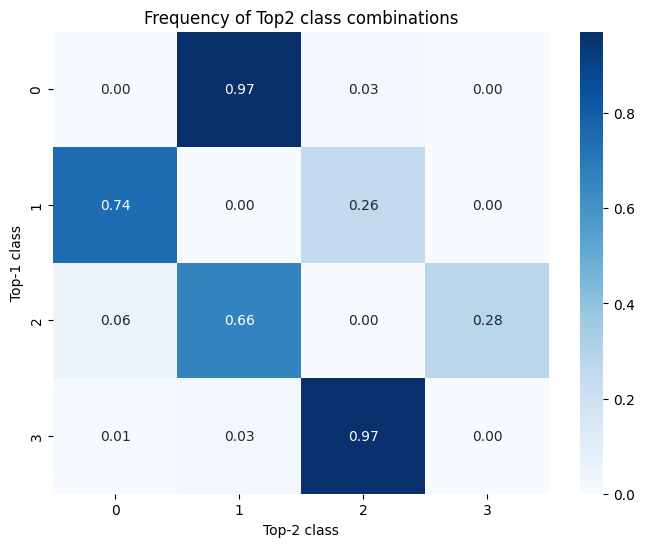

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = pair_counts.pivot(index="predicted_top1", columns="predicted_top2", values="count").fillna(0)
pivot_relative = pivot.div(pivot.sum(axis=1), axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_relative, annot=True, fmt=".2f", cmap="Blues")
plt.title("Frequency of Top2 class combinations")
plt.xlabel("Top-2 class")
plt.ylabel("Top-1 class")
plt.show()


### 2.2.3 Misclassification

In [58]:
errors_df = confusion_pairs[confusion_pairs["true_label"] != confusion_pairs["predicted_top1"]]
conf_matrix_errors = (
    errors_df
    .groupby(["true_label", "predicted_top1"])
    .size()
    .unstack(fill_value=0)
)

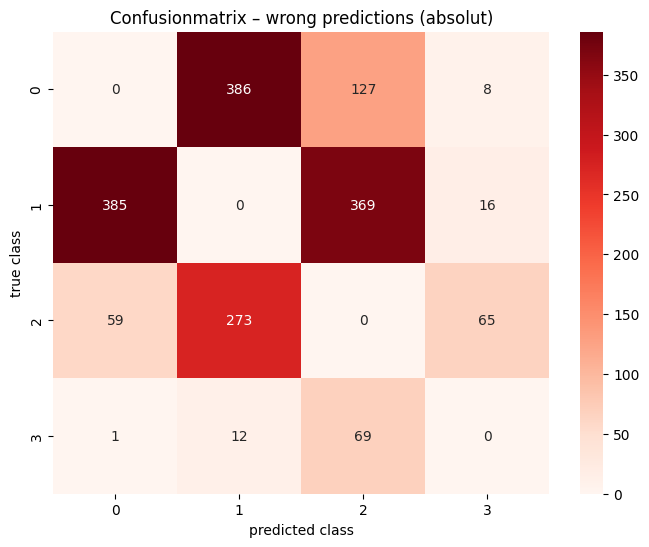

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_errors, annot=True, fmt=".0f", cmap="Reds")
plt.title("Confusionmatrix – wrong predictions (absolut)")
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.show()

### 2.2.4 Connection between max(p) and entropy

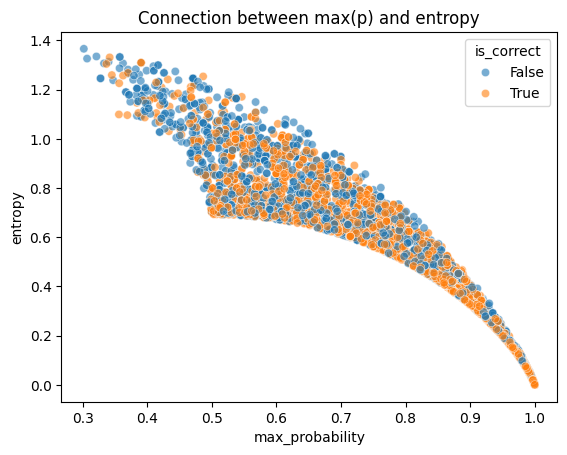

In [60]:
sns.scatterplot(data=confusion_pairs, x="max_probability", y="entropy", hue="is_correct", alpha=0.6)
plt.title("Connection between max(p) and entropy")
plt.show()

In [61]:
mask_high_conf = ((confusion_pairs["entropy"]< 0.7) & (confusion_pairs["max_probability"] > 0.5))

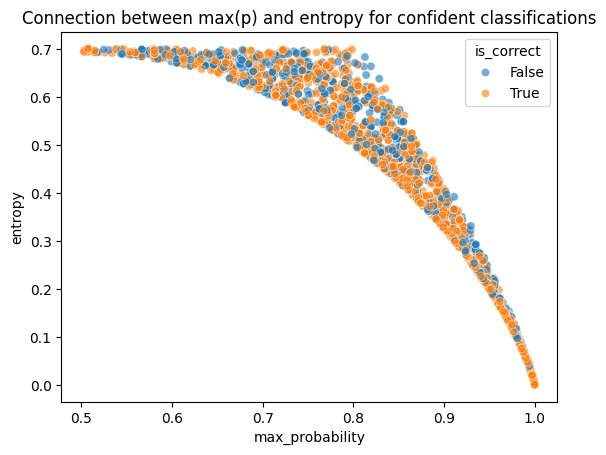

In [62]:
sns.scatterplot(data=confusion_pairs[mask_high_conf], x="max_probability", y="entropy", hue="is_correct", alpha=0.6)
plt.title("Connection between max(p) and entropy for confident classifications")
plt.show()

In [63]:
conf_and_correct = confusion_pairs[mask_high_conf]["is_correct"].mean()
print(f"Accuracy for conf. predictions: {conf_and_correct:.2%}")

Accuracy for conf. predictions: 68.27%


### 2.2.5 Uncertainty Max Probability

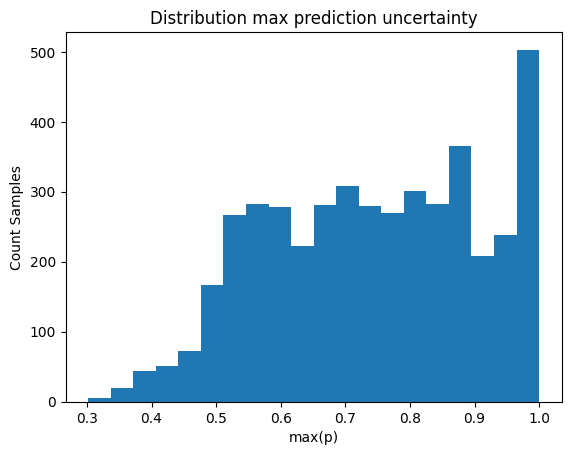

In [64]:
plt.hist(confusion_pairs["max_probability"], bins= 20)
plt.title("Distribution max prediction uncertainty")
plt.xlabel("max(p)")
plt.ylabel("Count Samples")
plt.show()

### 2.2.6 Uncertainty Entropy

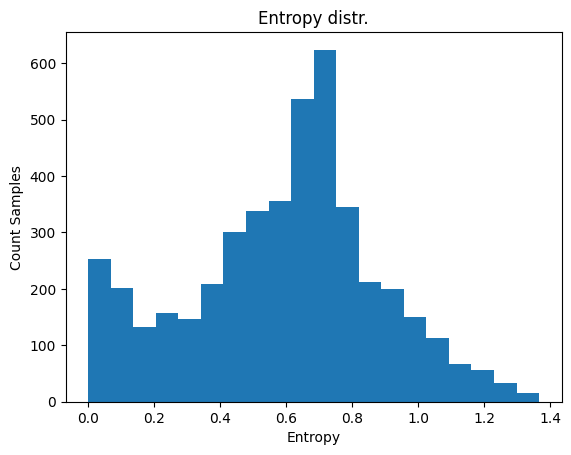

In [65]:
plt.hist(confusion_pairs["entropy"], bins= 20)
plt.title("Entropy distr.")
plt.xlabel("Entropy")
plt.ylabel("Count Samples")
plt.show()


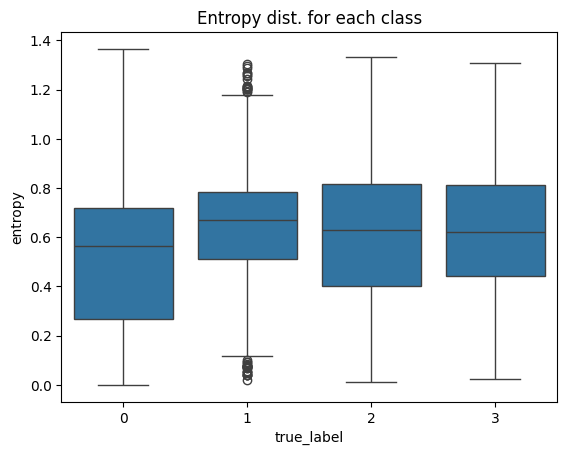

In [66]:
sns.boxplot(data=confusion_pairs, x="true_label", y="entropy")
plt.title("Entropy dist. for each class")
plt.show()


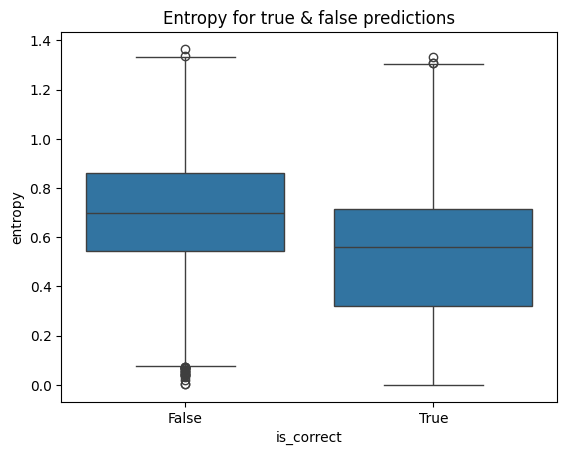

In [67]:
confusion_pairs["is_correct"] = confusion_pairs["true_label"] == confusion_pairs["predicted_top1"]

sns.boxplot(data=confusion_pairs, x="is_correct", y="entropy")
plt.title("Entropy for true & false predictions")
plt.show()


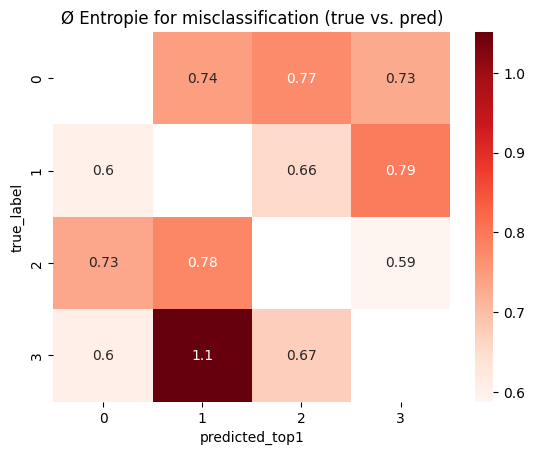

In [68]:
import numpy as np

error_only = confusion_pairs[~confusion_pairs["is_correct"]]
pivot_error_only = error_only.pivot_table(values="entropy", index="true_label", columns="predicted_top1", aggfunc="mean")

sns.heatmap(pivot_error_only, annot=True, cmap="Reds")
plt.title("Ø Entropie for misclassification (true vs. pred)")
plt.show()


## 2.3 Insights

In [69]:
import numpy as np
import pandas as pd
catnb_model = gs_catnb.best_estimator_
nb = catnb_model.named_steps["nb"]
encoder = catnb_model.named_steps["oe"]

# Klassen und Priors
classes = nb.classes_
priors = nb.class_count_ / nb.class_count_.sum()

# Dictionary für DataFrames: Key = Feature-Name, Value = DataFrame
feature_dfs = {}

for feat_name, cats, log_probs in zip(X_train.columns, encoder.categories_, nb.feature_log_prob_):
    # Bedingte Wahrscheinlichkeiten P(X|Y)
    probs_x_given_y = np.exp(log_probs)

    posterior_list = []
    for j, cat in enumerate(cats):
        numerators = probs_x_given_y[:, j] * priors
        denominators = numerators.sum()
        posterior_list.append(numerators / denominators)

    df = pd.DataFrame(posterior_list, index=cats, columns=classes)
    feature_dfs[feat_name] = df

df_feature = feature_dfs["educational_qualification"]
print(df_feature)

          0         1         2         3
1  0.432892  0.446483  0.114169  0.006456
2  0.900878  0.063070  0.018026  0.018026
3  0.416242  0.371518  0.193017  0.019223
4  0.278093  0.316686  0.358683  0.046538
5  0.230500  0.269853  0.427969  0.071678
6  0.516095  0.483841  0.000032  0.000032
7  0.515120  0.363623  0.121228  0.000030
8  0.756746  0.183785  0.043248  0.016221
9  0.698869  0.265997  0.031369  0.003765


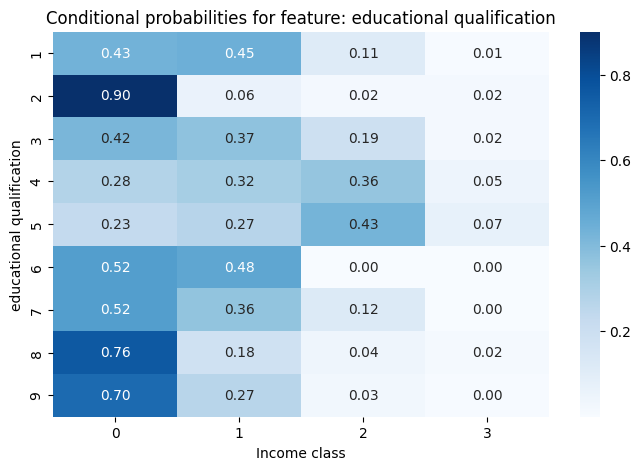

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(df_feature, annot=True, cmap="Blues", fmt=".2f")
plt.title("Conditional probabilities for feature: educational qualification")
plt.xlabel("Income class")
plt.ylabel("educational qualification")
plt.show()


# 3. MultinomialNB

## 3.1 Initial Model Pipeline

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB

pipe_mnb = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("nb", MultinomialNB())
])

## 3.2 Parameter Training

In [72]:

param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}

gs_mnb = run_gridsearch(pipe=pipe_mnb, param_grid=param_grid, X=X_train, y=y_train, name="MultiNB")

MultiNB best params: {'nb__alpha': 0.001} | best f1: 0.5518


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
_ = calculate_cv(gs_mnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.6115 ± 0.0040
f1_macro: 0.5518 ± 0.0110
neg_log_loss: -0.9987 ± 0.0206


In [74]:
y_pred_mnb = gs_mnb.predict(X_test)
y_probs_mnb = gs_mnb.predict_proba(X_test)
mnb_eval = evaluate_model(y_pred=y_pred_mnb, y_test=y_test, model_name="MultinomialNB",y_proba=y_probs_mnb)

MultinomialNB:
Accuracy: 0.602428603552957
Macro-F1: 0.5507745665897843
Weighted-F1: 0.6037257411070653
Log-Loss: 1.007529339215217
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      1741
           1       0.55      0.51      0.53      1581
           2       0.51      0.60      0.55       986
           3       0.39      0.42      0.41       139

    accuracy                           0.60      4447
   macro avg       0.55      0.56      0.55      4447
weighted avg       0.61      0.60      0.60      4447



# 4. ComplementNB

## 4.1 Initial Model Pipeline

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import ComplementNB

pipe_compnb = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("nb", ComplementNB())
])

## 4.2 Parameter Training

In [76]:

param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}

gs_compnb = run_gridsearch(pipe=pipe_compnb, param_grid=param_grid, X=X_train, y=y_train, name="ComplNB")

ComplNB best params: {'nb__alpha': 3.0} | best f1: 0.4815


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [77]:
_ = calculate_cv(gs_compnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.6114 ± 0.0037
f1_macro: 0.4815 ± 0.0086
neg_log_loss: -1.0389 ± 0.0146


In [78]:
y_pred_compnb = gs_compnb.predict(X_test)
y_probs_compnb = gs_compnb.predict_proba(X_test)
comp_eval = evaluate_model(y_pred=y_pred_compnb, y_test=y_test, model_name="ComplementNB",  y_proba=y_probs_compnb)

ComplementNB:
Accuracy: 0.6013042500562177
Macro-F1: 0.47302881925180545
Weighted-F1: 0.5889438891255109
Log-Loss: 1.0496850450223485
              precision    recall  f1-score   support

           0       0.70      0.75      0.73      1741
           1       0.59      0.41      0.49      1581
           2       0.49      0.72      0.58       986
           3       0.21      0.06      0.10       139

    accuracy                           0.60      4447
   macro avg       0.50      0.49      0.47      4447
weighted avg       0.60      0.60      0.59      4447



# 5. Comparison 

In [79]:
df_eval = pd.concat([
    catnb_eval,
    mnb_eval,
    comp_eval
    ], ignore_index = True)
df_eval

,Model,Accuracy,Macro-F1,Weighted-F1,Log-Loss
0,CategoricalNB,0.602429,0.550775,0.603726,1.007634
1,MultinomialNB,0.602429,0.550775,0.603726,1.007529
2,ComplementNB,0.601304,0.473029,0.588944,1.049685


In [80]:
model_comparison = data_load("data/model_comparison.csv")
model_comparison = pd.concat([
    model_comparison,
    df_eval
], ignore_index=True)
model_comparison

Data loaded!


,Model,Accuracy,Macro-F1,Weighted-F1,Log-Loss
0,Random_Guess,0.254104,0.227097,0.281148,1.386294
1,Majority_Guess,0.391500,0.140676,0.220298,21.932567
2,CategoricalNB,0.602429,0.550775,0.603726,1.007634
3,MultinomialNB,0.602429,0.550775,0.603726,1.007529
4,ComplementNB,0.601304,0.473029,0.588944,1.049685


In [81]:
save_df(model_comparison, "data/model_comparison.csv")

Data saved!
